# DES Y3

### Goals
- How to interface QP and sacc
- How to create n(z) uncertainties from an ensemble of n(z)'s

### Requirements
- **A sacc file**: we will use the sacc file of Prat et al 2022 (2212.09345). This sacc file contains the summary statistics measured from the CosmoDC2 simulations using the DESC TXPipe pipeline. The summary statistics include the angular power spectra of the shear-shear, position-shear, and position-position correlations, as well as the cross-correlations between the different probes. The sacc file also contains the redshift distributions of the galaxies in the simulations. For more details see Prat et al 2022. The data can found in NERSC at '/global/cfs/cdirs/lsst/groups/WL/projects/star-challenge/gaussian/data_vectors'.

- **A series of QP ensenbles**: For this tutorials I have created a series of QP ensembles using the cosmoDC2_v1.1.4_image_with_photoz_v1 simulations. This catalog contains photometric redshifts that were computed with the `BPZ` template-based code (https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract) by Sam Schmidt. We use all the available pixels and impose a 24.1 magnitude cut in the i-band following Prat et al. The edges of the tomographic bins are also taken from Prat et al.

### Special Dependencies
- **sacc**: standard DESC library to load and save data.
- **nz_prior**: this very own library, used to compute n(z) uncertainties from n(z) ensembles.
- **PACC** is a plotting library (https://github.com/JaimeRZP/pacc) for sacc files.

In [1]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as stats
import qp
import sacc
import yaml
import scipy
import nz_prior as nzp

### Make dictionaries

In [2]:
import pickle

with open('./data/final_nz_v7_sub12000_py3.pkl', 'rb') as f:
    lenses = pickle.load(f)

In [3]:
lenses_z = np.linspace(0.0, 2.0, 150)

In [4]:
nbins, nrels, nzs = lenses.shape
for i in range(nbins):
    hists = lenses[i, 0:999, :].T
    print(hists.shape)
    np.savez(f'./data/lenses/lenses_{i}.npz', znodes=lenses_z, photo_hists=hists)


(150, 999)
(150, 999)
(150, 999)
(150, 999)
(150, 999)
(150, 999)


In [5]:
from astropy.io import fits

hdu = fits.open('./data/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits')

In [6]:
sources_0_hists = []
sources_1_hists = []
sources_2_hists = []
sources_3_hists = []
for i in range(8, 1007):
    data = hdu[i].data
    sources_0_hists.append(data['BIN1'])
    sources_1_hists.append(data['BIN2'])
    sources_2_hists.append(data['BIN3'])
    sources_3_hists.append(data['BIN4'])

sources_0_hists = np.array(sources_0_hists).T
sources_1_hists = np.array(sources_1_hists).T
sources_2_hists = np.array(sources_2_hists).T
sources_3_hists = np.array(sources_3_hists).T

sources_z = hdu[8].data['Z_MID']

np.savez(f'./data/sources/sources_0.npz', znodes=sources_z, photo_hists=sources_0_hists)
np.savez(f'./data/sources/sources_1.npz', znodes=sources_z, photo_hists=sources_1_hists)
np.savez(f'./data/sources/sources_2.npz', znodes=sources_z, photo_hists=sources_2_hists)
np.savez(f'./data/sources/sources_3.npz', znodes=sources_z, photo_hists=sources_3_hists)

### Load Data

In [7]:
# Sacc file
s = sacc.Sacc.load_fits("/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc")
y = yaml.load(open("/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/gcgc_gcwl_wlwl.yml"), Loader=yaml.FullLoader)

# Ensembles
method = "bpz"
source_0 = np.load('./data/sources/sources_0.npz', allow_pickle=True)
source_1 = np.load('./data/sources/sources_1.npz', allow_pickle=True)
source_2 = np.load('./data/sources/sources_2.npz', allow_pickle=True)
source_3 = np.load('./data/sources/sources_3.npz', allow_pickle=True)

lens_0 = np.load('./data/lenses/lenses_0.npz', allow_pickle=True)
lens_1 = np.load('./data/lenses/lenses_1.npz', allow_pickle=True)
lens_2 = np.load('./data/lenses/lenses_2.npz', allow_pickle=True)
lens_3 = np.load('./data/lenses/lenses_3.npz', allow_pickle=True)
lens_4 = np.load('./data/lenses/lenses_4.npz', allow_pickle=True)
lens_5 = np.load('./data/lenses/lenses_5.npz', allow_pickle=True)

tomos = {'source_0': source_0,
        'source_1': source_1,
        'source_2': source_2,
        'source_3': source_3,
        'lens_0': lens_0,
        'lens_1': lens_1,
        'lens_2': lens_2,
        'lens_3': lens_3,
        'lens_4': lens_4,
        'lens_5': lens_5}

crosscorrs_method = "BinWise"

In [8]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        tomo = tracers_dict[key]
        nzs = tomo['photo_hists']
        zs = tomo['znodes']
        norms = np.sum(nzs, axis=0)
        print(len(norms))
        axis[0,i].plot(zs, nzs/norms, 'k-', alpha=0.01)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_ylim([-0.005, 0.1])
        axis[0,i].set_title(key)
        if i == 0:
            axis[0,i].set_ylabel(r'$p(z)$')
        else:
            axis[0,i].set_yticklabels([])
            axis[1,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

999
999
999
999


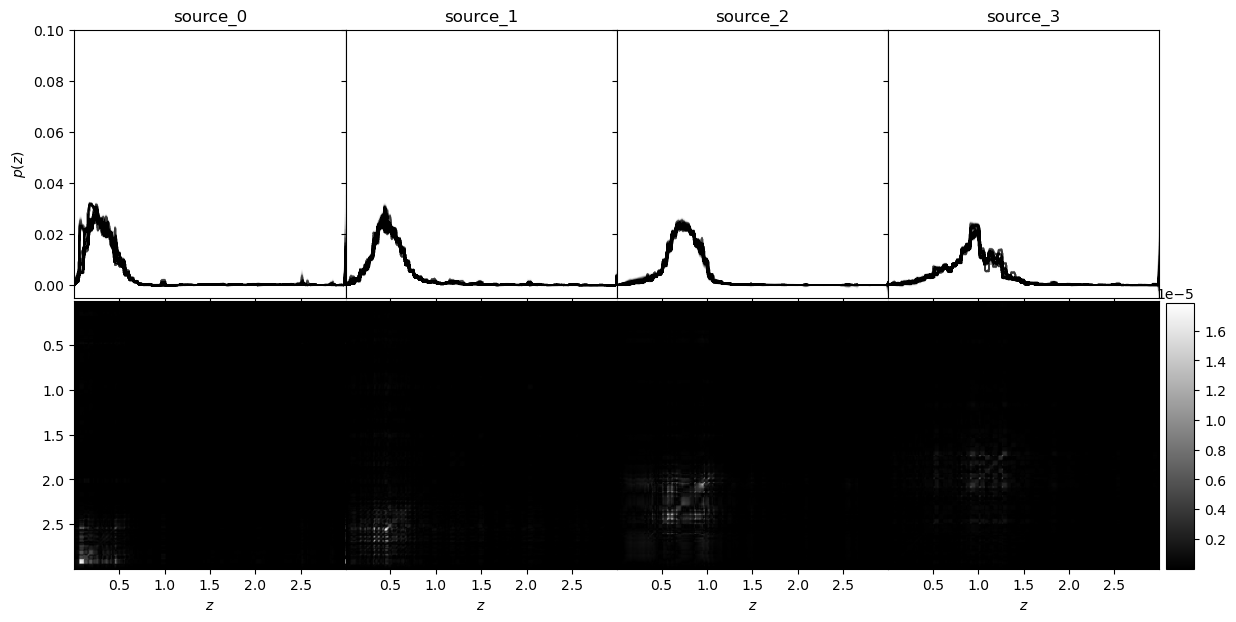

In [9]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3']
make_nzs_plots(tomos, plot_tracers)

999
999
999
999
999
999


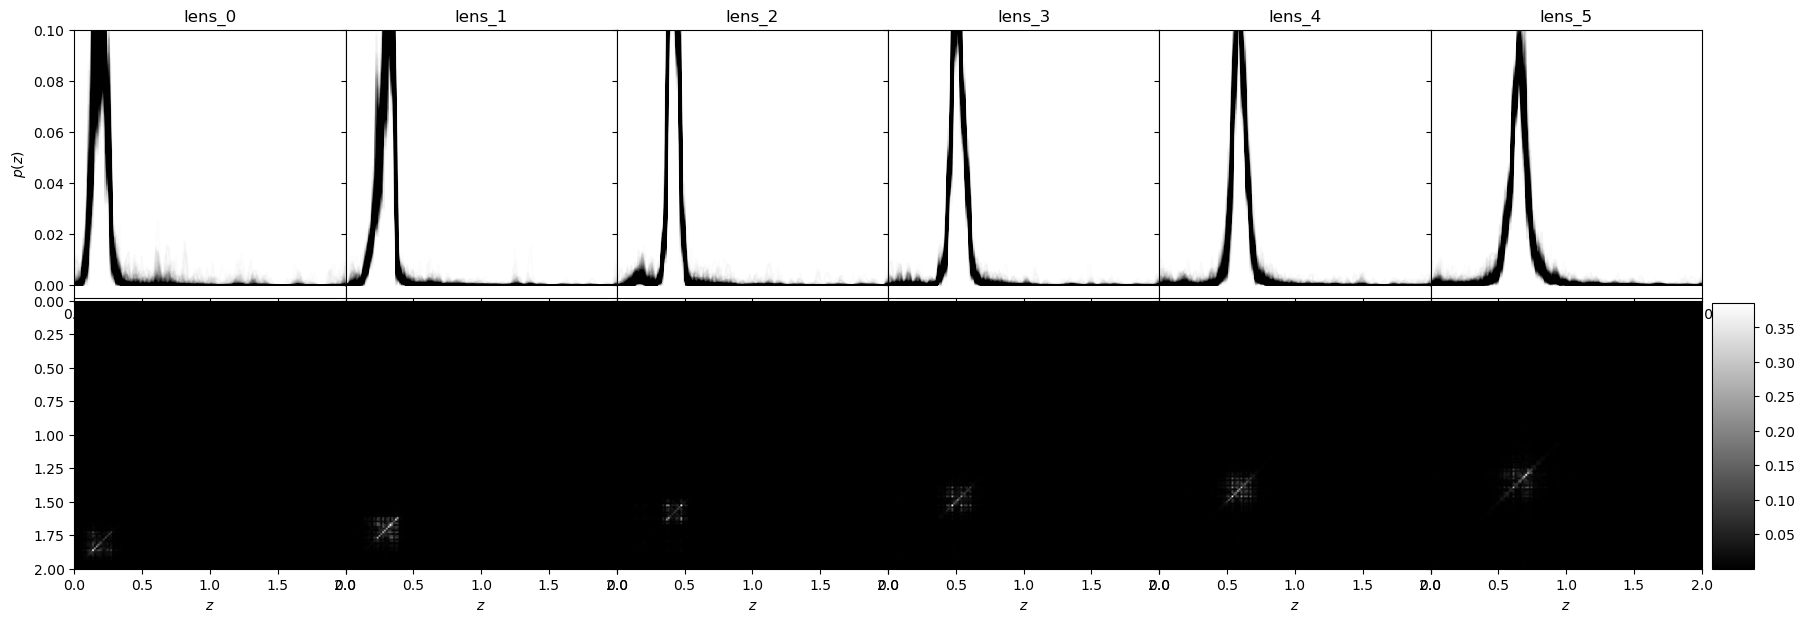

In [10]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4', 'lens_5']
make_nzs_plots(tomos, plot_tracers)

# Interfacing SACC and QP

In [11]:
def make_qp(ens):
    pzs = ens['photo_hists'].T
    zs = ens['znodes']
    dz = zs[1]-zs[0]
    zs_edges =np.concatenate([
        [zs[0] - dz / 2],  # First edge
        zs + dz / 2        # Rest of the edges
    ])
    print(len(zs_edges))
    return qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":pzs})

def update_sacc_qp(s, enss):
    ss = s.copy()
    tracers = ss.tracers
    for key in enss.keys():
        ens = enss[key]
        q = make_qp(ens)
        ss.add_tracer('Qpnz', key, q)
    return ss

ss_qp = update_sacc_qp(s, tomos)
ss_qp.remove_tracers(['source_4'])


301
301
301
301
151
151
151
151
151
151


# Computing Uncertainties

Now we are just going to apply the methods of nz_prior described in the basic tutorial for each of the tracers in the sacc file. For the sake of brevity we will only use the qp tracers but the same can be done for the NZTracers.

In [12]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        zs, nzs = tracers_dict[key]
        nzs = nzs.T
        axis[0,i].plot(zs, nzs, 'k-', alpha=0.01)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        #axis[0,i].errorbar(zs, nz_mean, yerr=np.sqrt(np.diag(cov)), fmt='k-')
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_title(key)
        axis[0,i].set_ylim([-0.01, 0.35])
        if i == 0:
            axis[0,i].set_ylabel(r'$p(z)$')
        else:
            axis[0,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

## Shifts

In [13]:
shifts_priors = nzp.PriorSacc(ss_qp, 
                            model="Shifts",
                            compute_crosscorrs="Full")

In [14]:
shifts_priors.sample_prior()

{'source_0__delta_z': -0.002850776351677615,
 'source_1__delta_z': -0.00071036359696873,
 'source_2__delta_z': 0.01082355477275931,
 'source_3__delta_z': -0.021894983516592706,
 'lens_0__delta_z': 0.00029145209179591813,
 'lens_1__delta_z': 0.001236471038452804,
 'lens_2__delta_z': 0.003298589612313797,
 'lens_3__delta_z': -0.010134422300281724,
 'lens_4__delta_z': 0.0064873211028749714,
 'lens_5__delta_z': 0.0007124336686308132}

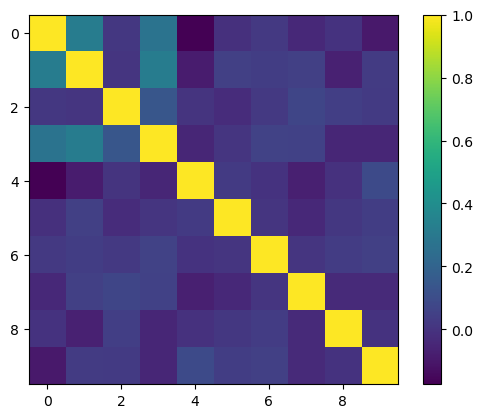

In [15]:
mean, cov, chol = shifts_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(corr)
plt.colorbar()

In [16]:
shifted_nzs = {}
for i in range(500):
    prior_sample = shifts_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = shifts_priors.model_objs[tracer_name]
        znew = np.linspace(0.0, 1.5, 50)
        nzmean_new = np.interp(znew, model_obj.z, model_obj.nz_mean)
        nz_fid = [znew, nzmean_new]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = [prior_sample[nz_name] for nz_name in nz_names]
        shifted_nz = nzp.shift_model(nz_fid, params[0])[1]
        if i == 0:
            shifted_nzs[tracer_name] = [nz_fid[0], shifted_nz]
        else:

            shifted_nzs[tracer_name] = [nz_fid[0], np.vstack([shifted_nzs[tracer_name][1], shifted_nz])]


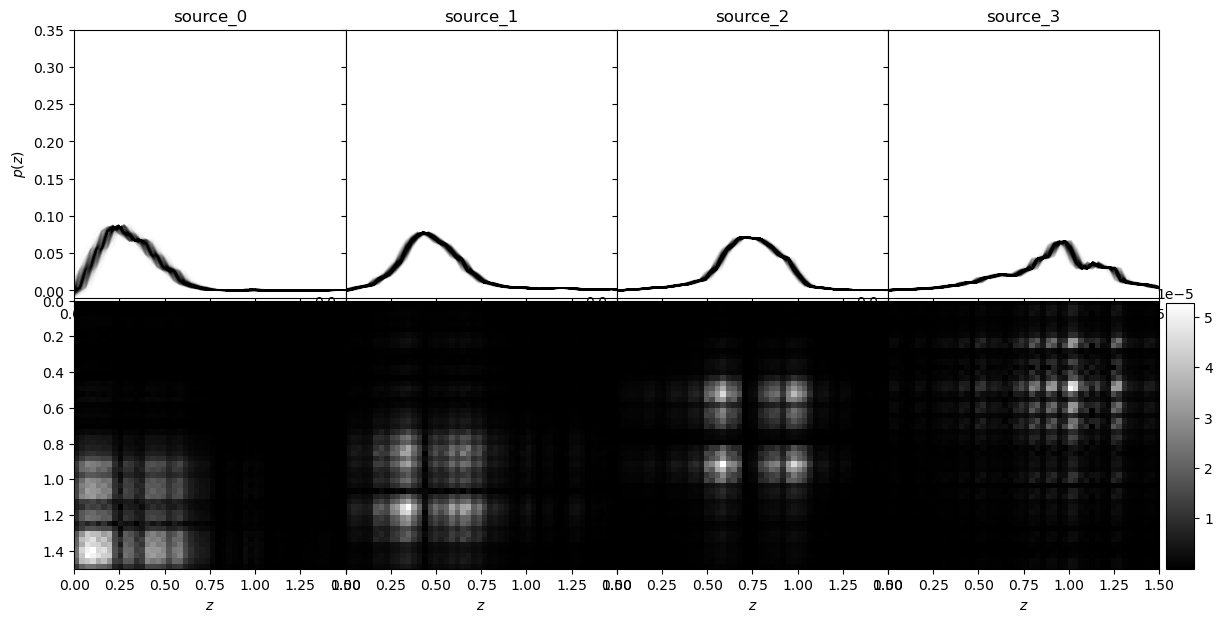

In [17]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3']
make_nzs_plots(shifted_nzs, plot_tracers)

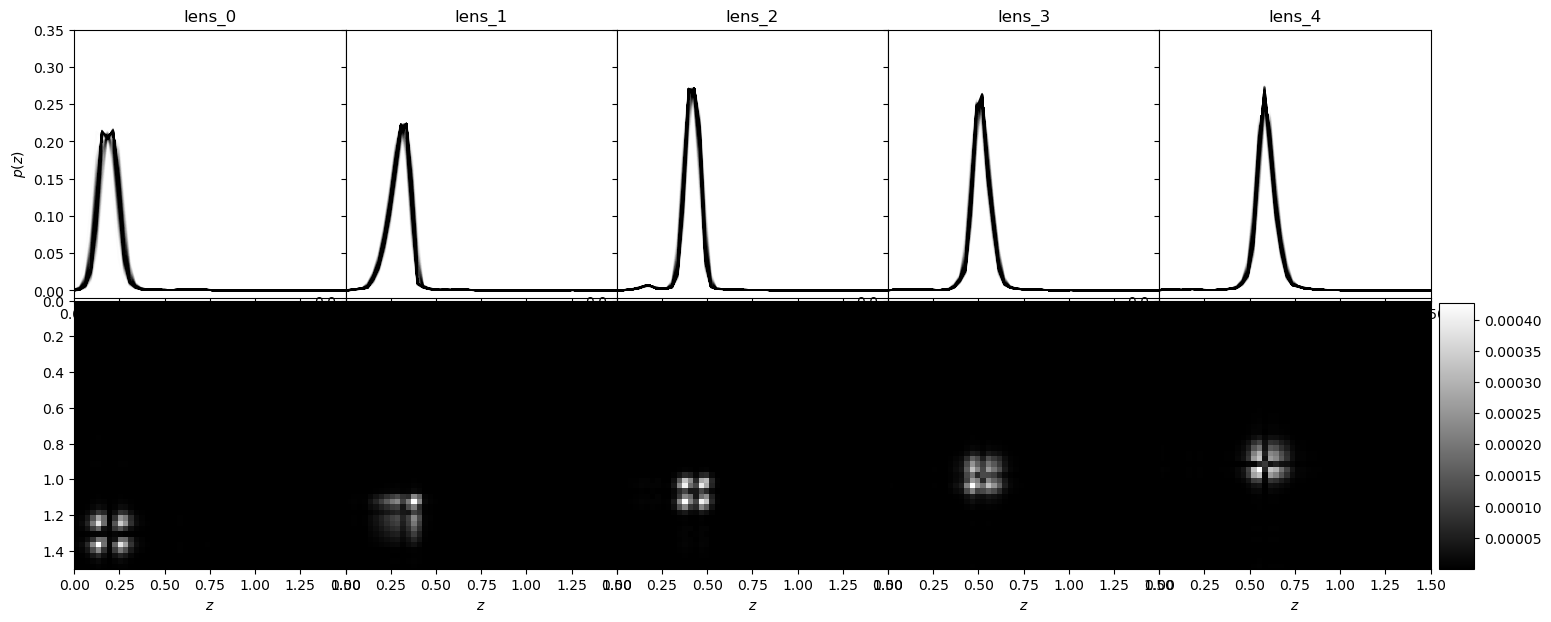

In [18]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(shifted_nzs, plot_tracers)

In [19]:
shifts_Ds = {}
for tracer_name in shifted_nzs.keys():
    model_obj = shifts_priors.model_objs[tracer_name]
    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
    nzs = shifted_nzs[tracer_name][1]
    mu_2 = np.mean(nzs, axis=0)
    K_2 = np.cov(nzs.T)
    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
    shifts_Ds[tracer_name] = np.abs(D)

The covariance matrix will be regularized
The covariance matrix will be diagonalized
The covariance matrix will be regularized
The covariance matrix will be diagonalized


ValueError: operands could not be broadcast together with shapes (300,) (50,) 

In [ ]:
shifts_Ds

## Shifts & widths

In [ ]:
SnWs_priors = nzp.PriorSacc(ss_qp, 
                            model="ShiftsWidths",
                            compute_crosscorrs="Full")

In [ ]:
SnWs_priors.sample_prior()

In [22]:
mean, cov, chol = SnWs_priors.get_prior()
file_name = "dz_prior.npz"
save_to = "/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_dz_{}_priors/".format(method) + file_name
np.savez(save_to, mean=mean, cov=cov)


In [ ]:
mean, cov, chol = SnWs_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(corr)
plt.colorbar()

In [ ]:
SnWs_priors.params_names    

In [ ]:
SnWs_priors.get_prior()

In [26]:
SnWs_nzs = {}
for i in range(500):
    prior_sample = SnWs_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = SnWs_priors.model_objs[tracer_name]
        znew = np.linspace(0.0, 1.5, 50)
        nzmean_new = np.interp(znew, model_obj.z, model_obj.nz_mean)
        nz_fid = [znew, nzmean_new]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = [prior_sample[nz_name] for nz_name in nz_names]
        shifted_nz = nzp.shift_and_width_model(nz_fid, params)[1]
        if i == 0:
            SnWs_nzs[tracer_name] = [nz_fid[0], shifted_nz]
        else:

            SnWs_nzs[tracer_name] = [nz_fid[0], np.vstack([SnWs_nzs[tracer_name][1], shifted_nz])]


In [ ]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3']
make_nzs_plots(SnWs_nzs, plot_tracers)

In [ ]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(SnWs_nzs, plot_tracers)

In [ ]:
SnWs_Ds = {}
for tracer_name in SnWs_nzs.keys():
    model_obj = SnWs_priors.model_objs[tracer_name]
    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
    nzs = SnWs_nzs[tracer_name][1]
    mu_2 = np.mean(nzs, axis=0)
    K_2 = np.cov(nzs.T)
    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
    SnWs_Ds[tracer_name] = np.abs(D)

In [ ]:
SnWs_Ds

## GP

In [20]:
z_new = np.linspace(0.0, 1.5, 50)

In [21]:
gp_priors = nzp.PriorSacc(ss_qp,
                          model="GP",
                          compute_crosscorrs=crosscorrs_method,
                          znodes=z_new)

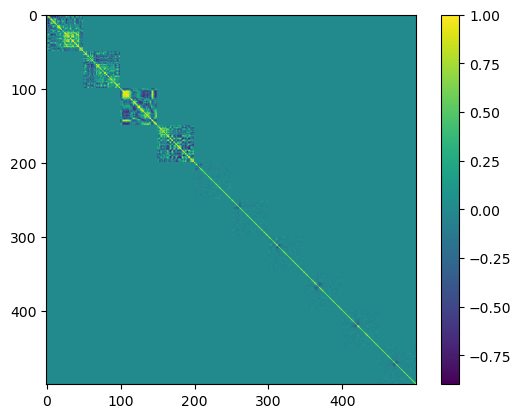

In [22]:
mean, cov, chol = gp_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(corr)
plt.colorbar()

In [23]:
gp_nzs = {}
for i in range(1000):
    prior_sample = gp_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = gp_priors.model_objs[tracer_name]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        nz = [prior_sample[nz_name] for nz_name in nz_names]
        z = model_obj.z
        if i == 0:
            gp_nzs[tracer_name] = [z, nz]
        else:

            gp_nzs[tracer_name] = [z, np.vstack([gp_nzs[tracer_name][1], nz])]

ValueError: x and y must have same first dimension, but have shapes (300,) and (50, 1000)

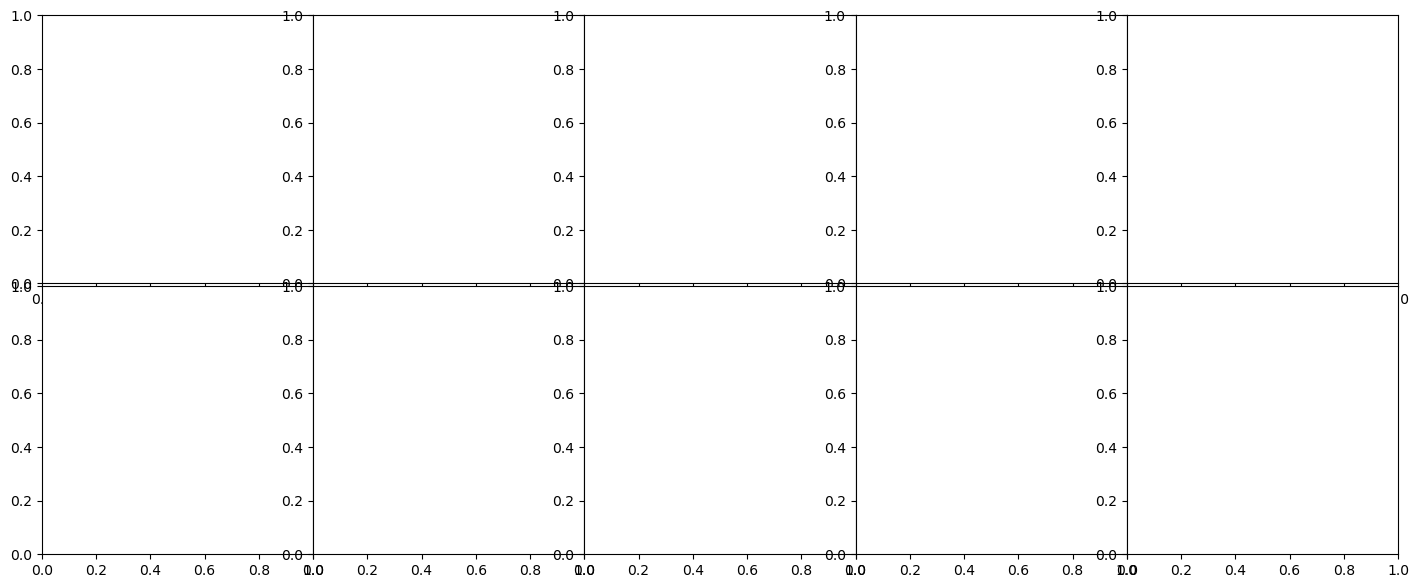

In [24]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(gp_nzs, plot_tracers)

In [ ]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(gp_nzs, plot_tracers)

In [ ]:
mean, cov, chol = gp_priors.get_prior()
for i, name in enumerate(ss_qp.tracers.keys()):
    z = ss_qp.tracers[name].z
    bins = 0.5*(z[1:] + z[:-1])
    sub_mean = mean[25*i:25*(i+1)]
    sub_cov = cov[25*i:25*(i+1), 25*i:25*(i+1)]
    print(sub_cov.shape)
    file_name = f"nz_{name}.npz"
    save_to = "/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_{}_priors/".format(method) + file_name
    np.savez(save_to, z=bins, dndz=sub_mean, cov=sub_cov)


In [39]:
gp_Ds = {}
for tracer_name in gp_nzs.keys():
    model_obj = gp_priors.model_objs[tracer_name]
    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
    nzs = gp_nzs[tracer_name][1]
    mu_2 = np.mean(nzs, axis=0)
    K_2 = np.cov(nzs.T)
    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
    gp_Ds[tracer_name] = np.abs(D)

In [ ]:
gp_Ds

## Comb

In [ ]:
comb_priors = nzp.PriorSacc(ss_qp,
                            model="Comb",
                            compute_crosscorrs=crosscorrs_method,
                            ncombs=10)

In [ ]:
mean, cov, chol = comb_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(corr)
plt.colorbar()

In [37]:
comb_nzs = {}
for i in range(500):
    prior_sample = comb_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = comb_priors.model_objs[tracer_name]
        znew = np.linspace(0.0, 1.0, 50)
        nzmean_new = np.interp(znew, model_obj.z, model_obj.nz_mean)
        nz_fid = [znew, nzmean_new]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = [prior_sample[nz_name] for nz_name in nz_names]
        nz = nzp.comb_model(nz_fid, params)[1]
        if i == 0:
            comb_nzs[tracer_name] = [nz_fid[0], nz]
        else:

            comb_nzs[tracer_name] = [nz_fid[0], np.vstack([comb_nzs[tracer_name][1], nz])]

In [ ]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3']
make_nzs_plots(comb_nzs, plot_tracers)

In [ ]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4', 'lens_5']
make_nzs_plots(comb_nzs, plot_tracers)

In [ ]:
comb_Ds = {}
for tracer_name in comb_nzs.keys():
    model_obj = comb_priors.model_objs[tracer_name]
    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
    nzs = comb_nzs[tracer_name][1]
    mu_2 = np.mean(nzs, axis=0)
    K_2 = np.cov(nzs.T)
    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
    comb_Ds[tracer_name] = np.abs(D)

In [ ]:
comb_Ds

# PCA

In [ ]:
PCA_priors = nzp.PriorSacc(ss_qp,
                            model="PCA",
                            compute_crosscorrs=crosscorrs_method,
                            npca=25)

In [ ]:
mean, cov, chol = PCA_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(corr)
plt.colorbar()

In [51]:
pca_nzs = {}
for i in range(500):
    prior_sample = PCA_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = PCA_priors.model_objs[tracer_name]
        znew = np.linspace(0.0, 1.0, 50)
        nzmean_new = np.interp(znew, model_obj.z, model_obj.nz_mean)
        nz_fid = [znew, nzmean_new]
        param_names = model_obj._get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        params = [prior_sample[nz_name] for nz_name in nz_names]
        nz = nzp.pca_model(nz_fid, params, model_obj.eigvecs)[1]
        if i == 0:
            pca_nzs[tracer_name] = [nz_fid[0], nz]
        else:

            pca_nzs[tracer_name] = [nz_fid[0], np.vstack([pca_nzs[tracer_name][1], nz])]

In [ ]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3']
make_nzs_plots(pca_nzs, plot_tracers)

In [ ]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4', 'lens_5']
make_nzs_plots(pca_nzs, plot_tracers)

In [ ]:
pca_Ds = {}
for tracer_name in pca_nzs.keys():
    model_obj = PCA_priors.model_objs[tracer_name]
    mu_1, K_1 = model_obj.nz_mean, model_obj.nz_cov
    nzs = pca_nzs[tracer_name][1]
    mu_2 = np.mean(nzs, axis=0)
    K_2 = np.cov(nzs.T)
    D = nzp.Sym_Dkl(mu_1, K_1, mu_2, K_2)
    pca_Ds[tracer_name] = np.abs(D)

# Comparison

In [55]:
def make_D_plots(Ds, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(1, n_tracers, figsize=(n_tracers*3.5,4))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        tracer_Ds = np.log10(1+np.array([D[key] for D in Ds]))
        axis[i].bar(np.arange(len(Ds)), tracer_Ds)
        axis[i].set_xticks(np.arange(5), ['Shifts', 'ShiftsWidths', 'PCA', 'Comb', 'GP'],
                           rotation=45)
        axis[i].set_title(key)
        if i == 0:
            axis[i].set_ylabel(r'$\log ((1/2)*[D_{KL}(f|g)+D_{KL}(g|f)])$')
        else:
            axis[i].set_yticklabels([])
    plt.show()

In [56]:
Ds = [shifts_Ds, SnWs_Ds, pca_Ds, comb_Ds, gp_Ds, ]

In [ ]:
make_D_plots(Ds, ['source_0', 'source_1', 'source_2', 'source_3'])

In [ ]:
make_D_plots(Ds, ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4', 'lens_5'])